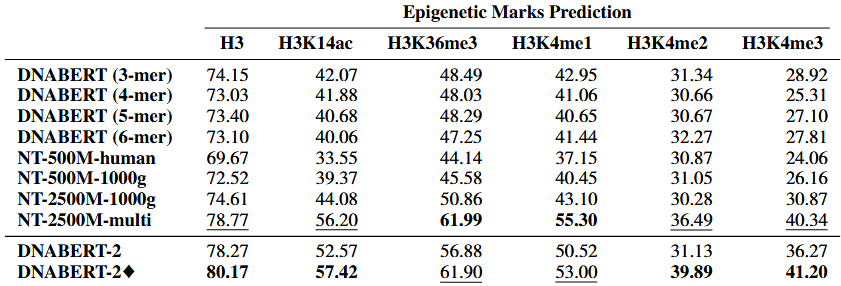

In [1]:
# standard libraries
import math
import os
import tempfile
from pathlib import Path
import json
import sys
import pickle

# standard scientific libraries
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from numpy import asarray, save, load
import pandas as pd
import seaborn as sns

# tensorflow
import tensorflow as tf
import tensorflow_addons as tfa
import keras
from keras.models import load_model
from keras.utils import to_categorical

# torch
import torch

# huggingface
from transformers import BertForSequenceClassification, PreTrainedTokenizerFast, AutoModelForSequenceClassification, AutoTokenizer, AutoModel
from datasets import load_dataset
import evaluate

# scikit-learn
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, average_precision_score, precision_recall_curve

2024-05-02 10:58:52.686114: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
/mimer/NOBACKUP/groups/naiss2024-5-16/tloop/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
/mimer/NOBACKUP/groups/naiss2024-5-16/tloop/lib/python3.10/site-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons sup

In [2]:
# Config

NUM_CLASSES = 2
BATCH_SIZE = 16
# DATA_PATH
# MODEL_DIR

# SET_NAME = str(DATA_DIR).split("/")[-1]
# RESULTS_DIR = Path(f"results/{SET_NAME}")
# if not RESULTS_DIR.exists():
#     RESULTS_DIR.mkdir(parents=True, exist_ok=True)

# def get_all_models(path):
#     models = {}
#     dirs = os.listdir(path)
#     for dir in dirs:
#         dir_path = f"{path}/{dir}"
#         if os.path.isdir(f"{dir_path}/results"):
#             eval_results = get_eval_results(dir_path)
#             best_trainer_state = get_trainer_state(get_best_model_path(dir_path))
#             models[dir] = {"eval_results": eval_results, "trainer_state": best_trainer_state}
#     return models


mpl.rcParams['figure.figsize'] = [8, 6]
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [3]:
def get_torch_labels_features(data_path):
    data = pd.read_csv(data_path)
    labels = list(data['label'])
    labels = to_categorical(labels, num_classes=NUM_CLASSES)
    features = list(data['sequence'])
    return labels, features


def get_tf_labels_features(data_path):
    matrices = np.load(data_path, allow_pickle=True)
    features = np.stack(matrices['arr_0'], axis=0)
    data_name = data_path.stem.split("_")[0]
    labels = np.load(data_path.parents[0]/f"{data_name}_labels.npy", allow_pickle=True)
    labels = to_categorical(labels, num_classes=NUM_CLASSES)
    return labels, features


def get_torch_model_tokenizer(model_dir):
    model = AutoModelForSequenceClassification.from_pretrained(model_dir, trust_remote_code=True)
    tokenizer = AutoTokenizer.from_pretrained(model_dir, trust_remote_code=True)
    # else: # NOTE this is for running it with base DNABERT2
    #     model = AutoModelForSequenceClassification.from_pretrained("zhihan1996/DNABERT-2-117M", trust_remote_code=True)
    #     tokenizer = AutoTokenizer.from_pretrained("zhihan1996/DNABERT-2-117M", trust_remote_code=True)
    return model, tokenizer


def get_tf_model(model_dir):
    model = load_model(model_dir, custom_objects={'f1': tfa.metrics.F1Score, 'mcc': tfa.metrics.MatthewsCorrelationCoefficient})
    return model


def get_torch_predictions(model, tokenizer, features): 
    
    # Tokenize texts and convert to tensors
    input = tokenizer(features, padding="longest", truncation=True, return_tensors='pt', max_length=tokenizer.model_max_length)
    
    # Forward pass to get predictions
    with torch.no_grad(): # Disabling gradient calculation, useful for inference
        output = model(**input)
        logits = output.logits
    
    # Get predicted probabilities
    predictions = torch.softmax(logits, dim=1).numpy()
    # predictions = predictions[:, 1].numpy()  # Assuming it's a binary classification task
    
    return predictions


def get_tf_predictions(model, features, batch_size = BATCH_SIZE):

    # Get predictions
    predictions = model.predict(features, batch_size=batch_size)

    return predictions


def get_torch_metrics(path): 
    with open(path, "r") as file:
        eval = json.load(file)
    metrics = {
            "loss": eval["eval_loss"],
            "accuracy": eval["eval_accuracy"],
            "precision": eval["eval_precision"],
            "recall": eval["eval_recall"],
            "f1": eval["eval_f1"],
            "mcc": eval["eval_matthews_correlation"]}
    return metrics


def get_tf_metrics(model, features, labels):
    metrics = model.evaluate(features, labels, batch_size=BATCH_SIZE, verbose=0)
    metrics = dict(zip(model.metrics_names, metrics))
    return metrics


def get_torch_history(path): # TODO is this for validation? or training
    with open(path, "r") as file:
        trainer_state = json.load(file)
    log_history = trainer_state["log_history"][2::3] # Every third entry contains these metrics
    epoch = [log["epoch"] for log in log_history]
    accuracy = [log["eval_accuracy"] for log in log_history]
    f1 = [log["eval_f1"] for log in log_history]
    loss = [log["eval_loss"] for log in log_history]
    mcc = [log["eval_matthews_correlation"] for log in log_history]
    precision = [log["eval_precision"] for log in log_history]
    recall = [log["eval_recall"] for log in log_history]
    history_dict = {"epoch": epoch, "accuracy": accuracy, "f1": f1, "loss": loss, "mcc": mcc, "precision": precision, "recall": recall}
    return history_dict


def get_tf_history(path):
    with open(path, "rb") as file:
        history = pickle.load(file)
    history_dict = {
        "epoch": list(range(len(history["loss"]))), # TODO should this be from the validation runs instead? val_loss etc. 
        "accuracy": history["accuracy"],
        "f1": history["f1"],
        "loss": history["loss"],
        "mcc": history["mcc"],
        "precision": history["precision"],
        "recall": history["recall"]}
    return history_dict

In [35]:
# Tensorflow

DATA_PATH = Path("../data_generation/training_data/gnra_8_80_T/test_matrices.npz") # For Tensorflow, load the matrices .npz file
MODEL_DIR = Path("results/ANN/gnra_8_80_T")

labels, features = get_tf_labels_features(DATA_PATH) # .argmax(axis=1) 
model = get_tf_model(MODEL_DIR)
predictions = get_tf_predictions(model, features)
metrics = get_tf_metrics(model, features, labels)
history = get_tf_history(MODEL_DIR/"history")

# Turn labels and predictions into non-categorical
labels, predictions = labels.argmax(axis=1), predictions.argmax(axis=1)

259/259 [==============================] - 0s 1ms/step


In [11]:
# PyTorch

DATA_PATH = Path("../data_generation/training_data/gnra_8_80_T/test.csv") 
MODEL_DIR = Path("results/DNABERT2/alvis/tetraloop/gnra_8_80_T_1")
# DATA_PATH = Path("results/DNABERT2/old/gnra_f14_r80_m3/model_data/test.csv") 
# MODEL_DIR = Path("results/DNABERT2/old/gnra_f14_r80_m3/output")

labels, features = get_torch_labels_features(DATA_PATH)
model, tokenizer = get_torch_model_tokenizer(MODEL_DIR)
predictions = get_torch_predictions(model, tokenizer, features)

metrics = get_torch_metrics(MODEL_DIR/"eval_results.json")
history = get_torch_history(MODEL_DIR/"trainer_state.json")

# Turn labels and predictions into non-categorical
labels, predictions = labels.argmax(axis=1), predictions.argmax(axis=1)

# Add missing metrics
metrics["auc"] = roc_auc_score(labels, predictions)
metrics["prc"] = average_precision_score(labels, predictions)
cm = confusion_matrix(labels, predictions)
metrics["tp"], metrics["fp"], metrics["tn"], metrics["fn"] = cm[1][1], cm[0][1], cm[0][0], cm[1][0]

/cephyr/users/xinhex/Alvis/.cache/huggingface/modules/transformers_modules/zhihan1996/DNABERT-2-117M/d064dece8a8b41d9fb8729fbe3435278786931f1/bert_layers.py:126: UserWarning: Unable to import Triton; defaulting MosaicBERT attention implementation to pytorch (this will reduce throughput when using this model).
  warnings.warn(


In [12]:
# Plotting functions # TODO make plots pretty

def plot_metrics(history):
    metrics = ['loss', 'precision', 'recall'] #! PRC not in
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(2,2,n+1)
        plt.plot(history["epoch"], history[metric], color=colors[0], label='Train')
        # plt.plot(history["epoch"], history['val_' + metric], color=colors[0], linestyle="--", label='Test') 
        plt.xlabel('Epoch')
        plt.ylabel(name)
        if metric == 'loss':
            plt.ylim([0, plt.ylim()[1]])
        elif metric == 'auc':
            plt.ylim([0.8,1])
        else:
            plt.ylim([0,1])

    plt.legend()


def plot_loss(history, label, n):
    # Use a log scale on y-axis to show the wide range of values.
    plt.semilogy(history["epochs"], history["loss"], color=colors[n], label='Train ' + label)
    # plt.semilogy(history["epochs"], history['val_loss'], color=colors[n], label='Val ' + label, linestyle="--")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')


def plot_confusion_matrix(labels, predictions, p=0.5): # TODO random threshold selected for CM
    cm = confusion_matrix(labels, predictions > p) 
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion matrix')
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    
    print('Non-GNRA Detected (True Negatives): ', cm[0][0])
    print('Non-GNRA Incorrectly Detected (False Positives): ', cm[0][1])
    print('GNRA Missed (False Negatives): ', cm[1][0])
    print('GNRA Detected (True Positives): ', cm[1][1])
    print('Total GNRA: ', np.sum(cm[1]))


def plot_roc(name, labels, predictions, auc, **kwargs):
    fpr, tpr, _ = roc_curve(labels, predictions)  # fpr=false positive rate = fp/(fp+tn), tpr=true positive rate = tp/(tp+fn)
    
    plt.rcParams['font.size'] = '16'
    plt.plot(100*fpr, 100*tpr, label=f'{name} (AUC = {auc:.2f})', linewidth=2, **kwargs)
    plt.plot([0, 1], [0, 1], linestyle='--', color='grey', label='Random')
    plt.title('Receiver operating characteristic (ROC) curve')
    plt.xlabel('False positives rate = fp/(fp+tn)')
    plt.ylabel('True positives rate = tp/(tp+fn)')
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')
    plt.legend(loc='lower right')
    # plt.grid()
    # plt.show()


def plot_prc(name, labels, predictions, **kwargs):  #precision = tp / (tp + fp), recall = tp / (tp + fn)
    precision, recall, _ = precision_recall_curve(labels, predictions)
    plt.rcParams['font.size'] = '9'
    plt.plot(precision, recall, label=name, linewidth=2, **kwargs)
    plt.xlabel('Recall = TP / (TP + FP)')
    plt.ylabel('Precision = TP / (TP + FN)')
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')
    plt.legend(loc='upper right')


# TODO BELOW THIS IS FOR MULTICLASS, REFACTOR LATER

# def plot_cm_multiclass(labels, predictions):
#     unique_labels = sorted(set(labels))  # Get unique labels and sort them
#     cm = confusion_matrix(labels, np.argmax(predictions, axis=1), labels=unique_labels)
    
#     plt.figure(figsize=(20, 10))
#     ax = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=unique_labels, yticklabels=unique_labels)
#     plt.title('Confusion Matrix')
#     plt.xlabel('Predicted Label')
#     plt.ylabel('True Label')
#     for text in ax.texts:
#         text.set_fontsize(8)
#     plt.show()
    
#     for label in unique_labels:
#         idx = unique_labels.index(label)
#         true_positive = cm[idx, idx]
#         false_positive = np.sum(cm[:, idx]) - true_positive
#         false_negative = np.sum(cm[idx, :]) - true_positive
#         true_negative = np.sum(cm) - true_positive - false_positive - false_negative
        
#         print(f"Label {label}:")
#         print('True Positives:', true_positive)
#         print('False Positives:', false_positive)
#         print('False Negatives:', false_negative)
#         print('True Negatives:', true_negative)
#         precision = true_positive / (true_positive + false_positive) if (true_positive + false_positive) > 0 else 0
#         recall = true_positive / (true_positive + false_negative) if (true_positive + false_negative) > 0 else 0
#         print('Precision:', precision)
#         print('Recall:', recall)
#         print('--------------------')

# # Plot ROC curve.
# def plot_roc(name, labels, predictions, **kwargs):
#     n_classes = predictions.shape[1]
#     fpr = dict()
#     tpr = dict()
    
#     line_styles = ['-', '--', '-.', ':']
#     colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple',
#               'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan', 'black']
    
#     for i in range(n_classes):
#         fpr[i], tpr[i], _ = sklearn.metrics.roc_curve(labels == i, predictions[:, i])

#     plt.figure(figsize=(8, 6))
#     for i in range(n_classes):
#         linestyle = line_styles[i % len(line_styles)]
#         color = colors[i % len(colors)]
#         plt.plot(100 * fpr[i], 100 * tpr[i], label=f'{name} (Class {i})', linewidth=2, linestyle=linestyle, color=color, **kwargs)

#     plt.xlabel('False Positive Rate (%)')
#     plt.ylabel('True Positive Rate (%)')
#     plt.xlim([-5, 100])
#     plt.ylim([0, 105])
#     plt.grid(True)
#     plt.legend(loc='center left', fontsize='small', bbox_to_anchor=(1.05, 0.5), title='Legend', title_fontsize='medium', ncol=3)
#     ax = plt.gca()
#     ax.set_aspect('equal')
#     plt.subplots_adjust(right=0.7)  # Adjust the figure size to accommodate the legend
#     plt.show()

# # Plot precision-recall curve
# def plot_prc(name, labels, predictions):
    # n_classes = predictions.shape[1]
    
    # line_styles = ['-', '--', '-.', ':']
    # colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple',
    #       'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan', 'black']
    
    # plt.figure(figsize=(8, 6))
    # for i in range(n_classes):
    #     linestyle = line_styles[i % len(line_styles)]
    #     color = colors[i % len(colors)]
    
    #     precision, recall, _ = sklearn.metrics.precision_recall_curve(labels == i, predictions[:, i])
    #     plt.plot(recall, precision, label=f'{name} (Class {i})', linewidth=2, linestyle=linestyle, color=color)

    # plt.xlabel('Recall')
    # plt.ylabel('Precision')
    # plt.grid(True)
    # plt.legend(loc='center left', bbox_to_anchor=(1.05, 0.5), fontsize='small', title='Legend', title_fontsize='medium', ncol=3)
    # plt.gca().set_aspect('equal')
    # plt.show()

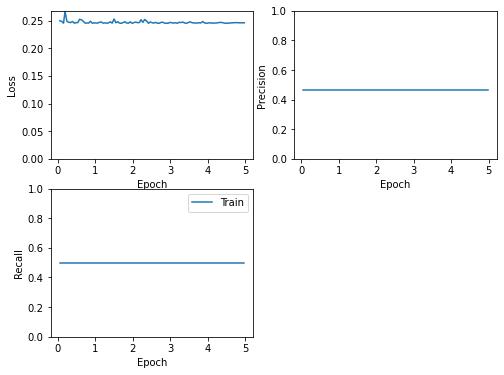

In [13]:
plot_metrics(history)

Non-GNRA Detected (True Negatives):  3841
Non-GNRA Incorrectly Detected (False Positives):  0
GNRA Missed (False Negatives):  295
GNRA Detected (True Positives):  0
Total GNRA:  295


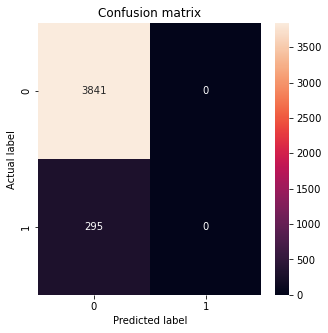

In [14]:
plot_confusion_matrix(labels, predictions)

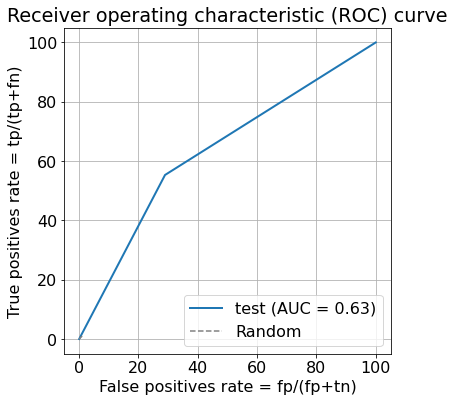

In [18]:
plot_roc("test", labels, predictions, metrics["auc"])

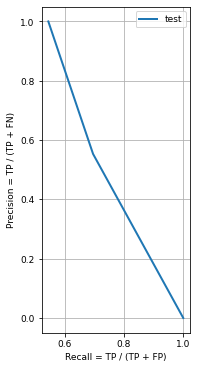

In [19]:
plot_prc("test", labels, predictions)

In [ ]:
# TODO Calculate hypergeometric distribution
import numpy as np

from scipy.stats import hypergeom

import matplotlib.pyplot as plt

[M, n, N] = [20, 7, 12]

rv = hypergeom(M, n, N)
x = np.arange(0, n+1)
pmf_dogs = rv.pmf(x)